# Track overlap vs. Fluence

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cr39py.etch.overlap import single_diameter_overlap_fraction, mrn_overlap_fraction, mrn_distribution
from cr39py.etch.track_overlap_mc import MonteCarloTrackOverlap

As the fluence on a piece of CR-39 increases, so does the chance that two or more tracks may overlap. While in principle it is possible to detect partially overlapping tracks and count them correctly, current generation scanning technology typically attempts to discard these tracks. The result is that, as fluence increases, the effective detection efficency of CR-39 begins to decrease.

cr39py includes a simple Monte-Carlo simulation tool, inspired by A.B. Zylstra et al. 2012, to calculate the fraction of overlapped tracks.

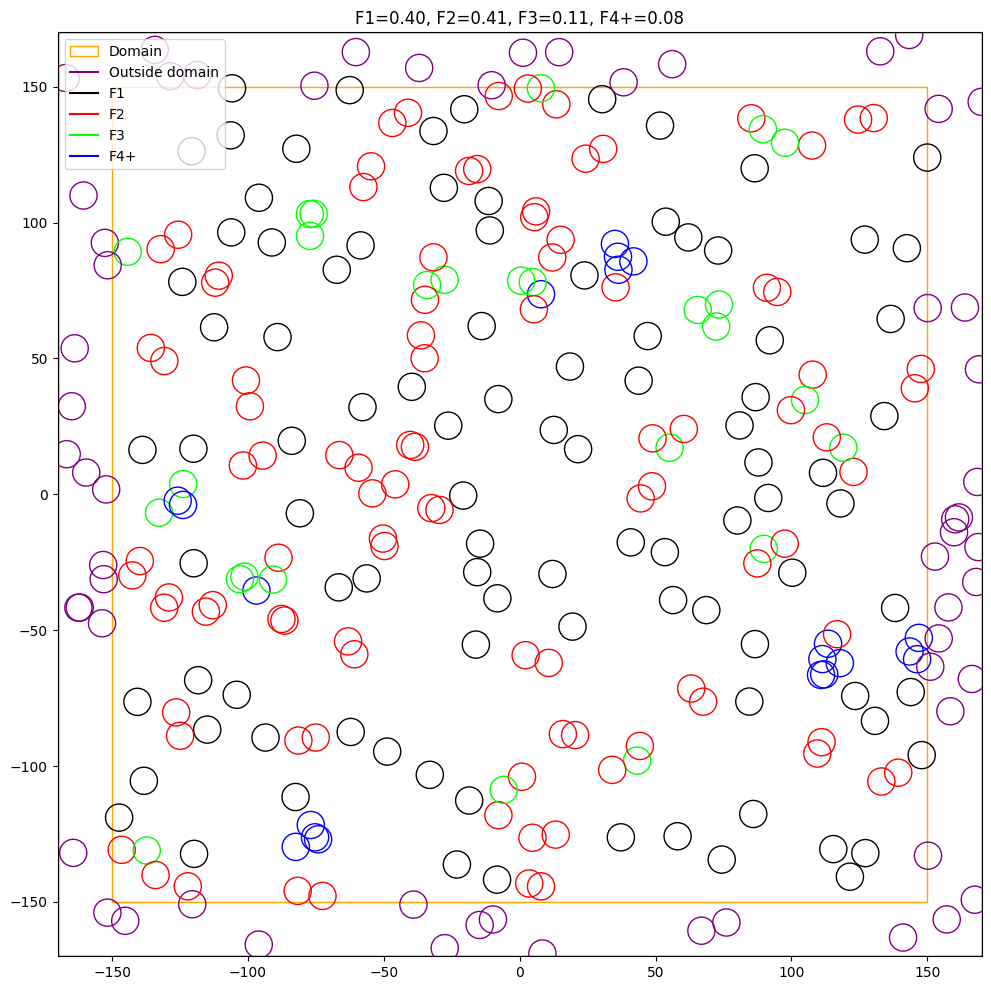

In [3]:
mc = MonteCarloTrackOverlap(framesize=300, border=20, diameters_mean=10, diameters_std=0)
xyd = mc.draw_tracks(300)
mc.plot_tracks(xyd)

The simulation class includes methods to run large numbers of these simulations in parallel, which generally take at least several minutes to complete.

## Track overlap curves 

A.B. Zylstra et al. 2012 introduced definitions for track overlap fractions. In cr39py, track overlap curve Fn is:
- F1 is the fraction of tracks with no overlaps.
- F2 is the fraction of tracks with one overlapping track.
- F3 is the fraction of tracks with two overlapping tracks.
- F4+ is the fraction of tracks with three or more overlapping tracks. 

Commonly, we want the fraction of tracks with one or more overlaps, 1-F1, since this is the fraction of tracks that are 
essentially lost during scanning.

Note that this definition is slightly different from the one in A.B. Zylstra et al. 2012, where tracks in a cluster of three tracks,
each of which overlap one of the others, are assigned F=3, rather than F=2.



## Overlap fraction for single-diameter or Gaussian track diameter distributions

A.B. Zylstra et al. 2012 simulated track overlap curves for distributions of tracks with either a single diameter or a Gaussian distribution of diameters. For single diameter distributions, or Gaussian distributions with small widths, Zylstra et al. show that the resulting track overlap vs. fluence curves can be made unique if expressed as a function of a dimensionless parameter

$$
\chi = \eta \bar D^2
$$

Where $\eta$ is the fluence in tracks/cm^2 and $\bar D$ is the mean track diameter in the frame. The resulting output curves are bundled with cr39py, and can be interpolated over using the `single_diameter_overlap_fraction` function.

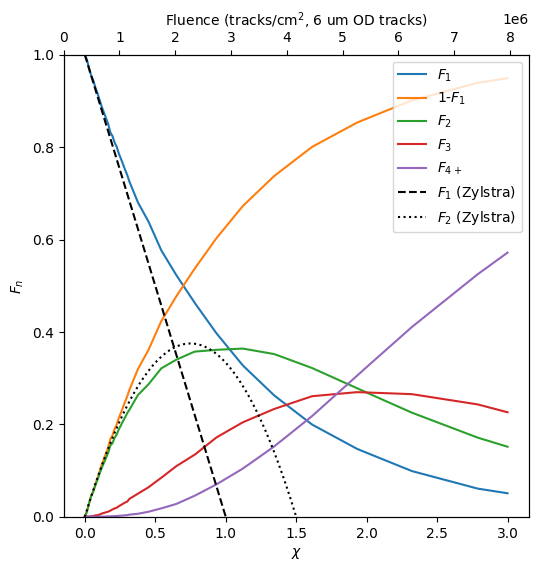

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("$\chi$")
ax.set_ylabel("$F_n$")
ax.set_ylim(0,1)
chi = np.linspace(0,3,num=200)
fluence = chi / (6*1e-4)**2 # Fluence for 6 um OD tracks in tracks/cm^2
ax2 = ax.twiny()
ax2.set_xlim(np.min(fluence), np.max(fluence))
ax2.set_xlabel("Fluence (tracks/cm$^2$, 6 um OD tracks)")

for Fnum in [1,-1, 2,3,4]:
    Fn = single_diameter_overlap_fraction(Fnum,chi=chi)
    match Fnum:
        case -1:
            lbl = '1-$F_1$'
        case 4:
            lbl = '$F_{4+}$'
        case _:
            lbl = f'$F_{Fnum}$'        
    ax.plot(chi,Fn, label=lbl)
    
F1_zylstra = 1 - chi
F2_zylstra = chi*(1-2*chi/3)
ax.plot(chi, F1_zylstra, label='$F_1$ (Zylstra)', color='k', linestyle='dashed')
ax.plot(chi, F2_zylstra, label='$F_2$ (Zylstra)', color='k', linestyle='dotted')
ax.legend(loc='upper right');

As the fluence increases, the fraction of tracks with no overlapping tracks ($F_1$) decreases, while the fraction of tracks with overlaps increases. 

A.B. Zylstra et al. 2012 derives approximate functions for $F_1$ and $F_2$ 

$$
F_1 = 1 - \chi \\
F_2 = \chi(1-2\chi/3)
$$

As noted in the paper, we see that these models fit well only for relatively low fluence, $\chi < 0.3$

Since only some limited degree of track overlap is generally tolerable, these curves can be used to determine the approximate maximum acceptable fluence for a given track diameter.

## Track overlap curves for realistic CR-39 track diameter distributions

While particles collected on CR-39 often originally have a Gaussian energy distribution, they typically pass through filtration prior to reaching the CR-39. By definition, particles of interest pass near their Bragg peak in the filtration, introducing some skew in the output energy distribution. The energy to diameter function given by the B. Lahmann et al. two parameter model is also non-linear. As a result, the actual diameter distribution on the CR-39 is often better described using the following function 

\begin{equation}
P(d) \propto \exp[-\frac{(d_{max}/d-1)^2}{2\sigma^2}]
\end{equation}

Because of its similarity to the [Reciprocal Normal Distribution](https://en.wikipedia.org/wiki/Inverse_distribution#Reciprocal_normal_distribution), we refer to this as the Modified Reciprocal Normal (MRN) distribution. 

The modifications here provide a physical meaning for the parameters: $d_{max}$ is the most probable diameter (peak of the distribution) in $\mu$m while $\sigma$ remains the standard deviation of the input Gaussian energy distribution.

Text(0, 0.5, 'P(d)')

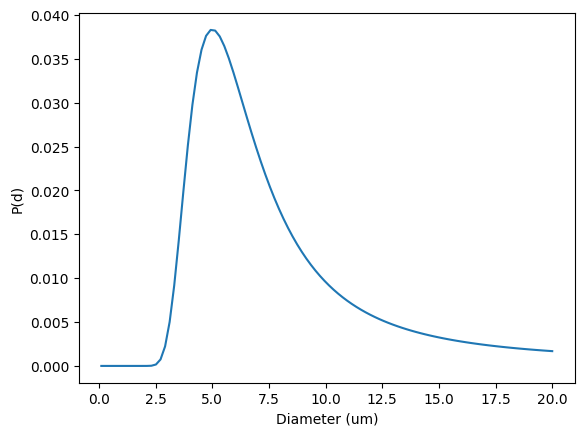

In [ ]:
dax = np.linspace(0.1, 20, num=100)
dmax_array = [2,5,8,10]
sigma = 0.3
mrn = mrn_distribution(dax, dmax, sigma)

fig, ax = plt.subplots()
ax.plot(dax, mrn)
ax.set_xlabel("Diameter (um)")
ax.set_ylabel("P(d)")
ax.set_title(f"$\sigma$ = {sigma:.2f} MeV")